# GUIA 3
### Facundo L. Sanchez

In [1]:
import numpy as np
from scipy.special import hyp1f1
from scipy import integrate
from scipy.misc import derivative
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import time as tm
from math import factorial
from scipy.special import sph_harm as Yml
import pandas as pd

from __future__ import division

%matplotlib inline

In [2]:
def R1F1(n,l,z,r):
    rho = 2 * r * z / n
    rnum = (2 * z / n)**3 * factorial(n + l)
    rden = (factorial(2*l+1))**2 * 2*n * factorial(n-l-1)
    rnorm = np.sqrt(rnum/rden)
    rfunc = (rho)**l * np.exp(-rho/2) * hyp1f1(-n+l+1, 2*l+2, rho)
    R = rnorm * rfunc
    return R

# Espectro del Helio

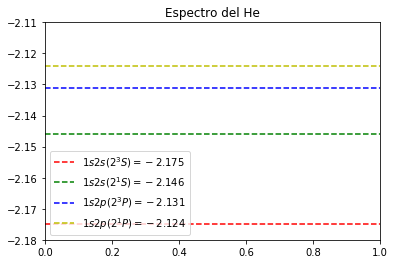

In [3]:
Es = [-2.175,-2.146,-2.131,-2.124 ]
colors = list("rgby")
labs = ['$1s2s(2^3S)={:.3f}$','$1s2s(2^1S)={:.3f}$', '$1s2p(2^3P)={:.3f}$', '$1s2p(2^1P)={:.3f}$']
for E,lab,color in zip(Es,labs,colors):
    plt.axhline(E,linestyle='dashed',label=lab.format(E),color=color)
plt.ylim((-2.18,-2.11))
plt.title("Espectro del He")
plt.legend(loc='best')
plt.show()

# Energia de los terminos con diferentes aproximaciones

In [ ]:
# Valor medio de la derivada orden k de r
def drk_Mean(n,l,Z,k):
    return integrate.quad(lambda r: R1F1(n,l,Z,r)*derivative(lambda d: R1F1(n,l,Z,d),r,dx=1e-5,n=k)*r**2, 0, np.inf)[0]

# Valor medio de r^(-k1)*d^k2/dr^k2
def rk1_prod_drk2_Mean(n,l,Z,k1,k2):
    return integrate.quad(lambda r: R1F1(n,l,Z,r)*derivative(lambda d: R1F1(n,l,Z,d),r,dx=1e-5,n=k2)*r**(2-k1), 0, np.inf)[0]

# Valor medio de r^(-k)
def rk_Mean(n,l,Z,k):
    return integrate.quad(lambda r: R1F1(n,l,Z,r)*R1F1(n,l,Z,r)*r**(2-k), 0, np.inf)[0]

# Valor medio del potencial efectivo
def Veff_Mean(n,l,Z,alpha):
    return integrate.quad(lambda r: R1F1(n,l,Z,r)*R1F1(n,l,Z,r)*r*(np.exp(-alpha*r)+1), 0, np.inf)[0]

# Energias a Z constante
def energia_Z_const(n_list,l_list,Z):
    energias = []
    dr2Mean_1s = drk_Mean(1,0,Z,2)
    r1_prod_dr2_1s = rk1_prod_drk2_Mean(1,0,Z,1,1)
    rMean_1s = rk_Mean(1,0,Z,1)
    for n,l in zip(n_list, l_list):
        dr2Mean_nl = drk_Mean(n,l,Z,2)
        r1_prod_dr2_nl = rk1_prod_drk2_Mean(n,l,Z,1,1)
        rMean_nl = rk_Mean(n,l,Z,1)
        r2Mean_nl = rk_Mean(n,l,Z,2)
        T = -0.5*(dr2Mean_1s + dr2Mean_nl) + 0.5*l*(l+1)*r2Mean_nl - \
            r1_prod_dr2_1s - r1_prod_dr2_nl
        V = -Z*(rMean_1s + rMean_nl)
        energias.append(T + V)    
    return energias

In [4]:
# Energias para valores distintos de carga
def energia_Z1_Z2(n_list,l_list,Z1,Z2):
    energias = []
    dr2Mean_1s = drk_Mean(1,0,Z1,2)
    r1_prod_dr2_1s = rk1_prod_drk2_Mean(1,0,Z1,1,1)
    rMean_1s = rk_Mean(1,0,Z1,1)
    for n,l in zip(n_list, l_list):
        dr2Mean_nl = drk_Mean(n,l,Z2,2)
        r1_prod_dr2_nl = rk1_prod_drk2_Mean(n,l,Z2,1,1)
        rMean_nl = rk_Mean(n,l,Z2,1)
        r2Mean_nl = rk_Mean(n,l,Z2,2)
        T = -0.5*(dr2Mean_1s + dr2Mean_nl) + 0.5*l*(l+1)*r2Mean_nl - \
            r1_prod_dr2_1s - r1_prod_dr2_nl
        V = -0.5*(Z1+Z2)*(rMean_1s + rMean_nl)
        energias.append(T + V)    
    return energias

# Energia tomando un potencial efectiva
def energia_Veff(n_list,l_list,Z,alpha):
    energias = []
    dr2Mean_1s = drk_Mean(1,0,Z,2)
    r1_prod_dr2_1s = rk1_prod_drk2_Mean(1,0,Z,1,1)
    VeffMean_1s = Veff_Mean(1,0,Z,alpha)
    for n,l in zip(n_list, l_list):
        dr2Mean_nl = drk_Mean(n,l,Z,2)
        r1_prod_dr2_nl = rk1_prod_drk2_Mean(n,l,Z,1,1)
        VeffMean_nl = Veff_Mean(n,l,Z,alpha)
        r2Mean_nl = rk_Mean(n,l,Z,2)
        T = -0.5*(dr2Mean_1s + dr2Mean_nl) + 0.5*l*(l+1)*r2Mean_nl - \
            r1_prod_dr2_1s - r1_prod_dr2_nl
        V = -VeffMean_1s-VeffMean_nl
        energias.append(T + V)    
    return energias

# Energias de los términos

In [18]:
keys = ['1_1S', '2_1S', '2_3S', '2_1P', '2_3P']
energias_He = {key: [] for key in keys}
energias_C = {key: [] for key in keys}

n_list = [1,2,2,2,2]
l_list = [0,0,0,1,1]

Z_He = 2
Z_C = 6

### Producto de Hidrogenoides

In [19]:
# Helio
E = energia_Z_const(n_list,l_list,Z_He)
for e,key in zip(E,keys):
    energias_He[key].append(e)

In [20]:
# Carbono 4+
E = energia_Z_const(n_list,l_list,Z_C)
for e,key in zip(E,keys):
    energias_C[key].append(e)

### Carga efectiva

In [21]:
# Helio
E = energia_Z_const(n_list,l_list,Z_He-5/16)
for e,key in zip(E,keys):
    energias_He[key].append(e)

In [22]:
# Carbono 4+
E = energia_Z_const(n_list,l_list,Z_C-5/16)
for e,key in zip(E,keys):
    energias_C[key].append(e)

### $\psi_{1s}$ sin apantallar ($Z^{He}_{1s}=2$, $Z^{C4+}_{1s}=6$) y $\psi_{nl}$ completamente apantallada ($Z^{He}_{nl}=1$, $Z^{C4+}_{nl}=5$)

In [23]:
# Helio
E = energia_Z1_Z2(n_list,l_list,Z_He,Z_He-1)
for e,key in zip(E,keys):
    energias_He[key].append(e)

In [24]:
# Carbono 4+
E = energia_Z1_Z2(n_list,l_list,Z_C,Z_C-1)
for e,key in zip(E,keys):
    energias_C[key].append(e)

### Veff para $Z(r) = e^{-\alpha r}+1$

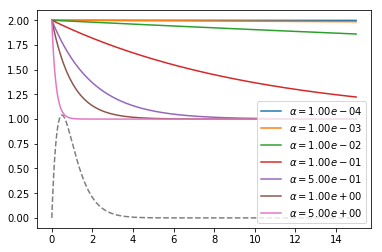

In [25]:
alphas = [1e-4,1e-3,1e-2,1e-1,0.5,1,5]
for alpha in alphas:
    r = np.linspace(0,15,1000)
    plt.plot(r,np.exp(-alpha*r)+1,label=r'$\alpha={:.2e}$'.format(alpha))
plt.plot(r,r*R1F1(1,0,2,r),'--')
plt.legend(loc='lower right')
plt.show()

In [26]:
# Helio
alpha = 0.5
E = energia_Veff(n_list,l_list,Z_He,alpha)
for e,key in zip(E,keys):
    energias_He[key].append(e)

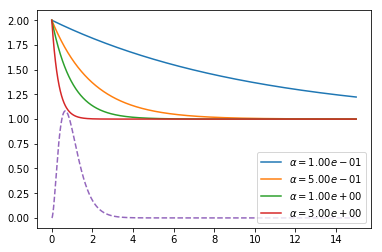

In [27]:
alphas = [1e-1,0.5,1,3]
for alpha in alphas:
    r = np.linspace(0,15,1000)
    plt.plot(r,np.exp(-alpha*r)+1,label=r'$\alpha={:.2e}$'.format(alpha))
plt.plot(r,r*R1F1(2,1,6,r),'--')
plt.legend(loc='lower right')
plt.show()

In [28]:
# Carbono 4+
alpha = 0.01
E = energia_Veff(n_list,l_list,Z_C,alpha)
for e,key in zip(E,keys):
    energias_C[key].append(e)

In [29]:
dfHe = pd.DataFrame(energias_He)
dfHe.index = ["Producto de Hidrogenoides", "Z-5/16", "nl Apantallada", "Veff"]
dfHe.index.name = "Aproximacion"
dfHe.columns.name = "Terminos"
dfHe

Terminos                       1_1S      2_1P      2_1S      2_3P      2_3S
Aproximacion                                                               
Producto de Hidrogenoides -4.000000 -2.500000 -2.500000 -2.500000 -2.500000
Z-5/16                    -2.847656 -1.779785 -1.779785 -1.779785 -1.779785
nl Apantallada            -2.000000 -1.250000 -1.250000 -1.250000 -1.250000
Veff                      -3.160494 -1.785047 -1.810647 -1.785047 -1.810647

In [30]:
dfC = pd.DataFrame(energias_C)
dfC.index = ["Producto de Hidrogenoides", "Z-5/16", "nl Apantallada", "Veff"]
dfC.index.name = "Aproximacion"
dfC.columns.name = "Terminos"
dfC

Terminos                        1_1S       2_1P       2_1S       2_3P  \
Aproximacion                                                            
Producto de Hidrogenoides -36.000001 -22.500000 -22.500000 -22.500000   
Z-5/16                    -32.347657 -20.217285 -20.217285 -20.217285   
nl Apantallada            -30.000000 -18.750000 -18.750000 -18.750000   
Veff                       12.019975   7.519946   7.519938   7.519946   

Terminos                        2_3S  
Aproximacion                          
Producto de Hidrogenoides -22.500000  
Z-5/16                    -20.217285  
nl Apantallada            -18.750000  
Veff                        7.519938

- No se muy bien porque me dio positivo el calculo con el Veff

# Integral de termino interelectronico para el 1s1s

In [35]:
J1s1s = 5/4 # Solucion analitica de la integral considerando el termino interelectronico para el 1s1s (griffiths)
E_1s1s = -4 + J1s1s
print "E(1s1s) =",E_1s1s

E(1s1s) = -2.75


# Calculo de integrales Directas ($J_{nl}$) e Intercambio ($K_{nl}$)

In [32]:
def rMayor(r1,r2):
    if r1 >= r2:
        return r1
    else:
        return r2

def rMenor(r1,r2):
    if r1 >= r2:
        return r2
    else:
        return r1

def Jnl(n,l,Z):
    func = lambda r1,r2: (R1F1(1,0,Z,r1)*r1*R1F1(n,l,Z,r2)*r2)**2/rMayor(r1,r2)
    return integrate.dblquad(func,0,np.inf,lambda r: 0, lambda r: np.inf)[0]

def Knl(n,l,Z):
    func = lambda r1,r2: 1/(2*l+1)*R1F1(1,0,Z,r1)*R1F1(n,l,Z,r1)*r1**2*R1F1(1,0,Z,r2)*R1F1(n,l,Z,r2)*r2**2*rMenor(r1,r2)**l/rMayor(r1,r2)**(l+1)
    return integrate.dblquad(func,0,np.inf,lambda r: 0, lambda r: np.inf)[0]

In [33]:
# Calculo las integrales para n = 2 y l = 0,1
J20 = Jnl(2,0,2)
J21 = Jnl(2,1,2)
K20 = Knl(2,0,2)
K21 = Knl(2,1,2)

In [34]:
E2_1S = -2.5 + J20 + K20
E2_3S = -2.5 + J20 - K20
E2_1P = -2.5 + J21 + K21
E2_3P = -2.5 + J21 - K20
print "Energia 2_1S =",E2_1S
print "Energia 2_3S =",E2_3S
print "Energia 2_1P =",E2_1P
print "Energia 2_3P =",E2_3P

Energia 2_1S = -2.03635116351
Energia 2_3S = -2.12414266325
Energia 2_1P = -1.98026214415
Energia 2_3P = -2.05829903913


# Variacional (No entendi como hacer variacional con funciones de onda que dependen de 2 variables)

# Diferentes iones con AutoStructure

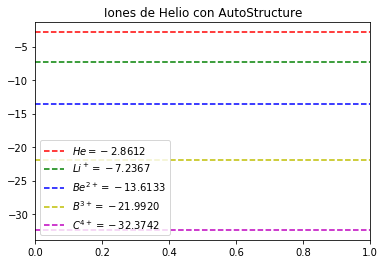

In [36]:
Iones = ["$He$","$Li^+$","$Be^{2+}$","$B^{3+}$","$C^{4+}$"]
E_AS = [-2.861193, -7.2366525, -13.6132645, -21.992011, -32.374202] # Valores obtenidos del autostructure
colors = list("rgbym")
for E,lab,color in zip(E_AS,Iones,colors):
    plt.axhline(E,linestyle='dashed',label=lab+"$={:.4f}$".format(E),color=color)
plt.title("Iones de Helio con AutoStructure")
plt.legend(loc='best')
plt.show()